<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_11_29_tryingAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gathering EDA for report content

## TODO - stuff I need to try..

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
!pip install --upgrade scikit-learn

#!pip uninstall scikit-learn -y
#!pip install scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [2]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 52
-rw------- 1 root root 29124 Nov 29 22:48 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [5]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [6]:
# install required libs
!pip install mido

In [7]:
# regular imports
import pandas as pd
import numpy as np

# scikit-learn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# graphics/ charts
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# misc
from scipy import stats
from collections import namedtuple
import math
import datetime
from itertools import cycle

In [8]:
import mido  # MIDI library processing
from mido import MidiFile
from mido import Message
from mido import tempo2bpm
from mido import tick2second

In [9]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-12-02 00:39:09.180513, module name: stats_n_features
>> LOADING custom module, when: 2020-12-02 00:39:09.182203, module name: data_prep
>> LOADING custom module, when: 2020-12-02 00:39:09.186543, module name: pipeline_utils


In [10]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2020-12-02 00:39:09.216728,  param:bling
Test function in stats_n_features called and worked! when: 2020-12-02 00:39:09.216946,  param:hello


## Pandas display options

In [11]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [12]:
##################################
######## LOAD

my_data = dp.load_all_data()
#my_data = dp.load_all_data(filter_err_buckets=False)
all_drummer_data = my_data.copy()

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.0: 'High Floor

## Single file tests..

In [13]:
##################################
######## EXPLORE SINGLE FILE

# experimenting on a single file here ...
key1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
#key2 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'

test_data = all_drummer_data[key1]
df1 = test_data.tight_df.copy()
df1.head()

print('stats for: {}'.format(key1))
df1['beat_offset'].groupby(df1['note']).describe()
df1['velocity'].groupby(df1['note']).describe()
df1.describe()

note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


,velocity,beat_offset,bar_beat_number
count,259.000000,259.000000,259.000000
mean,59.023166,-8.382239,7.528958
std,23.861508,16.705284,4.585338
min,8.000000,-58.000000,1.000000
25%,44.000000,-17.000000,3.000000
50%,52.000000,-7.000000,8.000000
75%,65.500000,1.500000,11.000000
max,127.000000,55.000000,16.000000


In [14]:
# pull out notes in named bars...
display(df1.xs(1, level='bar_number')) 
display(df1.xs(2, level='bar_number')) 

,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,55,7,1
1,kick,64,10,1
3,kick,57,-29,3
3,hh,31,-2,3
5,hh,54,-13,5
5,snare,93,-5,5
7,hh,42,-16,7
8,snare,33,-12,8
10,snare,33,-14,10


,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,42,-7,1
1,kick,55,-5,1
3,kick,62,-10,3
3,hh,41,3,3
5,snare,94,4,5
5,hh,51,5,5
7,hh,45,7,7
8,snare,32,7,8
9,hh,43,2,9


### Peek at file_df of same file

In [15]:
# extract unfiltered file_df to examine
tmp_file_df = test_data.file_df.copy()
tmp_file_df.head()
tmp_file_df.describe()
tmp_file_df['beat_offset'].groupby(tmp_file_df['note']).describe()
#tmp_file_df['velocity'].groupby(tmp_file_df['note']).describe()

track_msg_num  total_ticks  note  velocity  \
bar_number bar_beat_number note                                              
1          1               49             0:6            3    49        60   
                           51             0:7            7    51        55   
                           36             0:8           10    36        64   
           3               36            0:14          211    36        57   
                           51            0:16          238    51        31   

                                 beat_offset beat_center  bar_number  \
bar_number bar_beat_number note                                        
1          1               49              3           0           1   
                           51              7           0           1   
                           36             10           0           1   
           3               36            -29         240           1   
                           51             -2         240           1   

                                 bar_beat_number  
bar_number bar_beat_number note                   
1          1               49                  1  
                           51                  1  
                           36                  1  
           3               36                  3  
                           51                  3

,total_ticks,note,velocity,beat_offset,bar_number,bar_beat_number
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,15389.109848,43.981061,59.371212,-8.617424,8.609848,7.556818
std,8818.113292,6.914718,24.050930,16.746416,4.589132,4.579317
min,3.000000,36.000000,8.000000,-58.000000,1.000000,1.000000
25%,7893.250000,38.000000,44.000000,-18.000000,5.000000,3.000000
50%,15378.000000,38.000000,53.000000,-7.500000,9.000000,8.000000
75%,23034.000000,51.000000,66.000000,1.250000,13.000000,11.000000
max,30452.000000,51.000000,127.000000,55.000000,16.000000,16.000000


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
36,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.00,10.0
38,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.50,55.0
43,1.0,-21.000000,NaN,-21.0,-21.00,-21.0,-21.00,-21.0
49,4.0,-20.750000,18.264264,-37.0,-34.00,-24.5,-11.25,3.0
51,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.00,27.0


## Filter songs...

Take a look at all file names in the complete data set...

In [16]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

Code to pull out data to test, based on selected songs. Also add 'y' (target/ observation) label.

In [17]:

# FILTER SONGS BEING TESTED, ADD LABEL

def addLabelCol(df, label):
  '''
  Input: data_prep.PerformanceData.tight_df
  Return: df with additional colum for Y/ label called 'drummer_ID'
  '''
  df.insert(0, 'drummer_ID', label) # add it as first col
  return df

def load_songs(style_filter=[]):

  songs_data = []

  if len(style_filter) == 0:
    print('>>>> Loading all songs ...')
    for next_file in all_drummer_data.keys():
      perf_data = all_drummer_data[next_file]
      file_name = perf_data.file_wrapper.my_file_name
      print('  __{}'.format(file_name))
      df1 = perf_data.tight_df.copy()
      df2 = addLabelCol(df1, perf_data.drummer_id)  
      df2.reset_index(drop=True, inplace=True)
      songs_data.append(df2)
    print('>>>> DONE loading all songs.')
  else:
    for next_style in style_filter:
      print('>>>> Loading songs in style: {} ...'.format(next_style))

      # iterate through loaded files, extract songs
      # matching the any styles set in 'next_filter'
      for next_file in all_drummer_data.keys():
        perf_data = all_drummer_data[next_file]
        file_name = perf_data.file_wrapper.my_file_name
        if next_style in file_name:
          print('  __{}'.format(file_name))
          df1 = perf_data.tight_df.copy()
          df2 = addLabelCol(df1, perf_data.drummer_id)  
          df2.reset_index(drop=True, inplace=True)
          songs_data.append(df2)
        else:
          #print('  ... ignoring: {}'.format(file_name))
          pass
    print('>>>> DONE loading songs: {}'.format(style_filter))

  return songs_data

# specify style being processed
# 1_funk-groove1
# 3_soul-groove3
# 4_soul-groove4
# 6_hiphop-groove6
# 8_rock-groove8

#style_filter = "1_funk-groove1"  
#style_filter = "3_soul-groove3" 
#style_filter = "4_soul-groove4"
#style_filter = "6_hiphop-groove6"
#style_filter = "8_rock-groove8"

#filtered_songs = load_songs(style_filter=["4_soul-groove4"])
filtered_songs = load_songs(style_filter=[])

# load ALL songs ...
#working_songs = load_songs()

# merge all into single df, drop indexes, reset default index
working_data = pd.concat(filtered_songs)
working_data.reset_index(inplace=True, drop=True)

# .. at this point, df 'working_data' is a collection
# of data for the same song, across all drummers, with
# DrummerID label

working_data.head(5)


>>>> Loading all songs ...
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6

,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,hh,55,7,1
1,drummer1,kick,64,10,1
2,drummer1,kick,57,-29,3
3,drummer1,hh,31,-2,3
4,drummer1,hh,54,-13,5


# Stats on data being analysed

## Total notes per drummer in the data

In [18]:
print('DataFrame shape: {}\n'.format(working_data.shape))
print('Total notes per drummer...')
working_data.groupby(['drummer_ID'])['drummer_ID'].count() #describe() #['count']


DataFrame shape: (5631, 5)

Total notes per drummer...


drummer_ID
drummer1    1498
drummer5    1336
drummer7    1372
drummer8    1425
Name: drummer_ID, dtype: int64

## Total notes per drummer, per instrument/ hand

In [19]:
print('Total notes per drummer, per instrument...')
working_data.groupby(['drummer_ID', 'note'])['note'].count() #describe() #['count']
#working_data.groupby(['drummer_ID', 'note'])['note'].describe() #['count']

Total notes per drummer, per instrument...


drummer_ID  note 
drummer1    hh       872
            kick     327
            snare    299
drummer5    hh       732
            kick     331
            snare    273
drummer7    hh       801
            kick     330
            snare    241
drummer8    hh       830
            kick     347
            snare    248
Name: note, dtype: int64

## histograms

In [20]:
plt.rcParams["figure.figsize"] = (12,8)

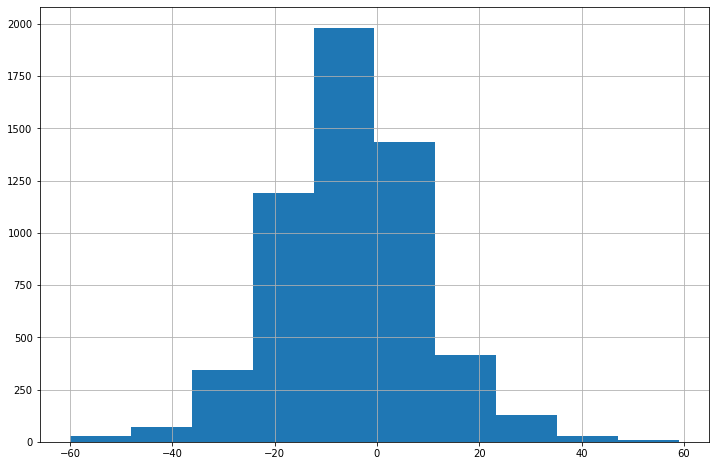

In [21]:
working_data.beat_offset.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6cf810ac8>,
      dtype=object)

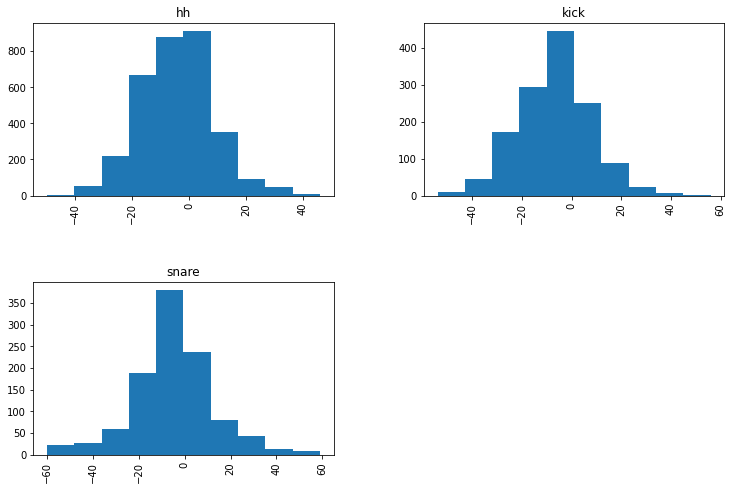

In [22]:
working_data.beat_offset.hist(by=working_data.note)

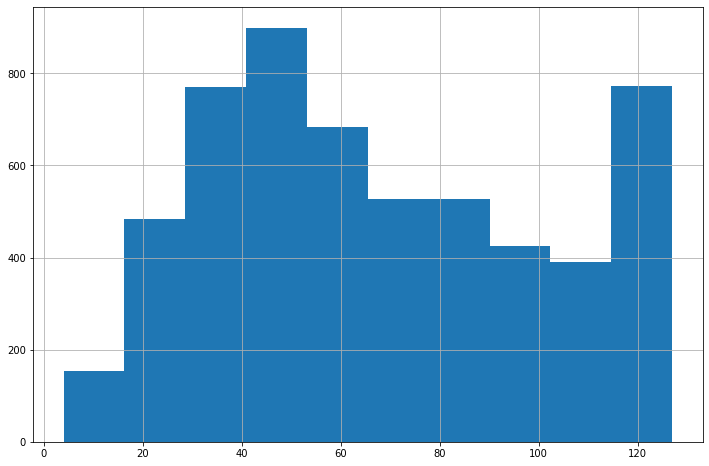

In [23]:
working_data.velocity.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6cf1bd320>,
      dtype=object)

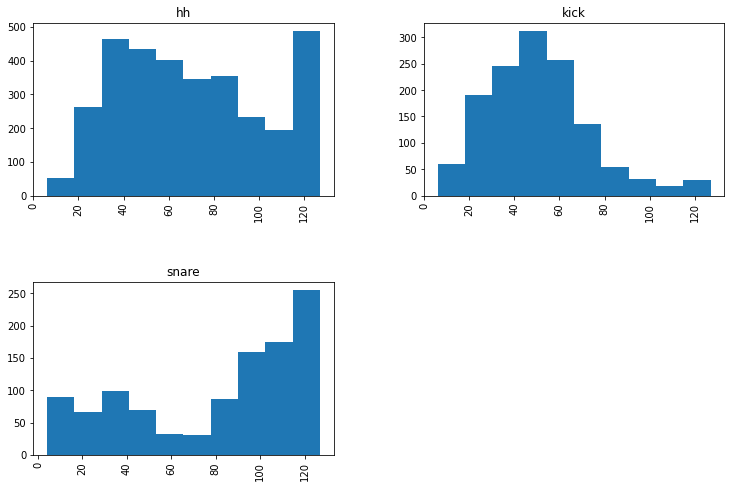

In [24]:
working_data.velocity.hist(by=working_data.note)

## Summary metrics per drummer, per instrument/ hand

In [25]:
working_data.groupby(['drummer_ID', 'note'])[['velocity', 'beat_offset']].describe() #['count']


velocity                                                   \
                    count        mean        std   min   25%    50%    75%   
drummer_ID note                                                              
drummer1   hh       872.0   57.323394  26.063968   6.0  36.0   50.0   79.0   
           kick     327.0   64.914373  20.343040  25.0  53.0   58.0   71.0   
           snare    299.0   74.749164  42.126774   5.0  30.0   93.0  111.0   
drummer5   hh       732.0   58.087432  24.014371  10.0  40.0   58.0   73.0   
           kick     331.0   29.329305   8.853540   6.0  22.5   31.0   35.5   
           snare    273.0   69.139194  39.021709   4.0  36.0   86.0  101.0   
drummer7   hh       801.0   76.121099  37.360327   7.0  43.0   67.0  120.0   
           kick     330.0   40.363636  11.700721  11.0  31.0   43.0   48.0   
           snare    241.0   82.062241  33.188732   5.0  64.0   94.0  105.0   
drummer8   hh       830.0   91.640964  29.025445   6.0  70.0   93.0  122.0   
           kick     347.0   66.979827  20.058502   6.0  54.0   65.0   76.0   
           snare    248.0  101.512097  34.942519   5.0  82.0  119.0  127.0   

                        beat_offset                                          \
                    max       count       mean        std   min   25%   50%   
drummer_ID note                                                               
drummer1   hh     127.0       872.0  -5.413991  10.732396 -41.0 -12.0  -5.0   
           kick   127.0       327.0  -9.883792  12.085532 -54.0 -16.0  -8.0   
           snare  127.0       299.0  -9.150502  15.711560 -58.0 -18.0  -8.0   
drummer5   hh     125.0       732.0  -7.517760  15.343614 -43.0 -18.0 -10.5   
           kick    48.0       331.0  -8.567976  14.183347 -50.0 -18.0  -8.0   
           snare  127.0       273.0  -2.890110  21.524670 -60.0 -14.0  -4.0   
drummer7   hh     127.0       801.0  -4.731586  13.901856 -50.0 -15.0  -4.0   
           kick    82.0       330.0 -10.151515  15.861140 -52.0 -22.0 -10.0   
           snare  127.0       241.0  -5.572614  16.994727 -55.0 -15.0  -5.0   
drummer8   hh     127.0       830.0  -0.037349  10.139785 -33.0  -7.0   0.0   
           kick   127.0       347.0  -1.259366  13.994286 -36.0  -9.0  -2.0   
           snare  127.0       248.0  -1.024194  16.263251 -60.0 -10.0  -2.0   

                              
                   75%   max  
drummer_ID note               
drummer1   hh      2.0  30.0  
           kick   -2.0  15.0  
           snare  -1.0  58.0  
drummer5   hh     -1.0  46.0  
           kick    0.0  35.0  
           snare  11.0  59.0  
drummer7   hh      5.0  38.0  
           kick    1.0  45.0  
           snare   4.0  59.0  
drummer8   hh      6.0  41.0  
           kick    6.0  56.0  
           snare   5.0  45.0

## Check correlations

In [26]:
def plotHeat(corr):
  ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
  
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );

### Working data, no pipe processing...

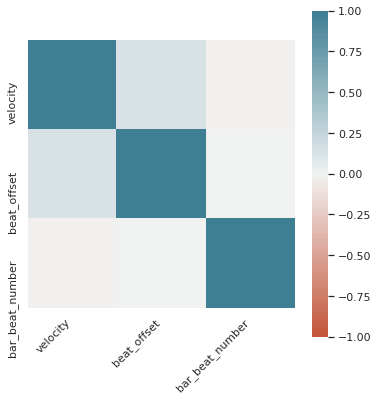

In [27]:
sns.set(rc={'figure.figsize':(6,6)})
plotHeat(working_data.corr())

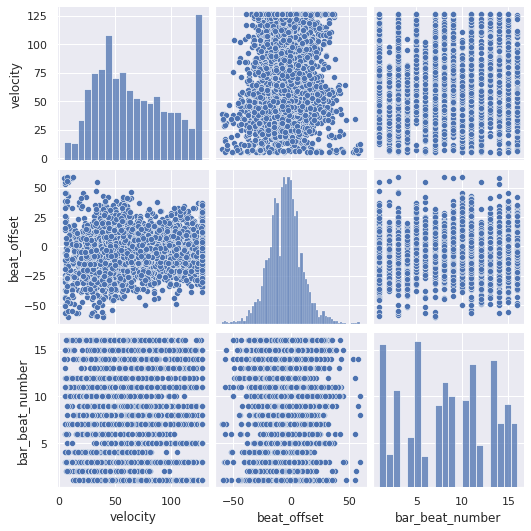

In [28]:
# Basic correlogram
sns.set(rc={'figure.figsize':(12,12)})
sns.pairplot(working_data)
plt.show()
